In [1]:
import time
from time import sleep
import random
from itertools import count
import matplotlib.pyplot as plt

import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY, COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace

import numpy as np

from DeepQ_Network import DQNetwork
from replay_from_memory import ReplayMemory
from wrappers import wrapper


Using TensorFlow backend.


In [2]:
FRAME_DIM = (84, 84, 4)
ACTION_SPACE = RIGHT_ONLY   # We can also use other action space COMPLEX_MOVEMENT( for left, right, up and down actions)
REPLAY_MEMORY_CAPACITY = 100_000
NUM_EPISODES = 1001
MAX_STEPS_PER_GAME = 1000
GAMMA = 0.99
RENDER_ENVIRONMENT = False

BATCH_SIZE = 32
TRAIN_FREQUENCE = 4  # number of total steps after which the policy model is trained
TARGET_NETWORK_UPDATE_FREQUENCE = 40_000  # number of total steps after which the weights of the policy model are copied to the target model

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.1
EXPLORATION_STEPS = 1_000_000
EXPLORATION_DECAY = (EXPLORATION_MAX - EXPLORATION_MIN) / EXPLORATION_STEPS

In [3]:
def get_next_action(state, action_space, current_exploration):
    """Returns the next action."""
    if np.random.rand() < current_exploration:
        return random.randrange(action_space)
    else:
        predicted_q_values = policy_net.model.predict(np.expand_dims(np.asarray(state).astype(np.float64), axis=0),
                                                      batch_size=1)
        return np.argmax(predicted_q_values[0])


In [4]:
def train_policy_model(replay_memory, policy_model, target_model):
    """Trains the policy net on a batch from the replay memory."""

    # if there are not enough transitions yet don't train
    if len(replay_memory) < BATCH_SIZE:
        return

    batch = replay_memory.sample(BATCH_SIZE)

    # get the target q values of the target model
    current_states = []
    target_predictions = []
    for state, action, reward, next_state, done in batch:
        # convert the states
        current_state = np.expand_dims(np.asarray(state).astype(np.float64), axis=0)
        next_state = np.expand_dims(np.asarray(next_state).astype(np.float64), axis=0)

        # get the prediction of the target network and the current policy network
        target_prediction = target_model.predict(next_state)
        target_q_value = np.max(target_prediction)
        current_prediction = policy_model.predict(current_state)[0]

        # calculate the new q values
        if done:
            current_prediction[action] = reward
        else:
            current_prediction[action] = reward + GAMMA * target_q_value

        current_states.append(current_state)
        target_predictions.append(target_prediction)

    # train the policy model based on the predictions of the target model
    policy_model.fit(np.asarray(current_states).squeeze(), np.asarray(target_predictions).squeeze(),
                     batch_size=BATCH_SIZE, verbose=0)


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

print(tf.__version__)

def check_GPU():
    local_devices = device_lib.list_local_devices()
    print("local_devices: ", local_devices)
    print("Available GPUs: ", tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


check_GPU()


1.15.0
local_devices:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6698144673776389373
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8699694327044935319
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11897235047
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17215180093721742435
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4762650600975869752
physical_device_desc: "device: XLA_GPU device"
]
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs












Episode:  0 reward:  232.0
Episode:  1 reward:  616.0
Episode:  2 reward:  245.0
Episode:  3 reward:  249.0
Episode:  4 reward:  248.0
Episode:  5 reward:  638.0
Episode:  6 reward:  995.0
Episode:  7 reward:  245.0
Episode:  8 reward:  1783.0
Episode:  9 reward:  792.0
Episode:  10 reward:  604.0
Episode:  11 reward:  888.0
Episode:  12 reward:  653.0
Episode:  13 reward:  653.0
Episode:  14 reward:  636.0
Episode:  15 reward:  611.0
Episode:  16 reward:  651.0
Episode:  17 reward:  670.0
Episode:  18 reward:  1304.0
Episode:  19 reward:  655.0
Episode:  20 reward:  248.0
Episode:  21 reward:  1053.0
Episode:  22 reward:  1324.0
Episode:  23 reward:  258.0
Episode:  24 reward:  789.0
Episode:  25 reward:  753.0
Episode:  26 reward:  629.0
Episode:  27 reward:  614.0
Episode:  28 reward:  792.0
Episode:  29 reward:  240.0
Episode:  30 reward:  840.0
Episode:  31 reward:  246.0
Episode:  32 reward:  742.0
Episode:  33 reward:  784.0
Episode:  34 reward:  231.0
Episode:  35 rew

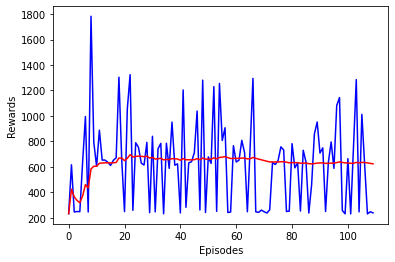

Episode:  110 reward:  619.0
Episode:  111 reward:  222.0
Episode:  112 reward:  231.0
Episode:  113 reward:  1237.0
Episode:  114 reward:  587.0
Episode:  115 reward:  662.0
Episode:  116 reward:  263.0
Episode:  117 reward:  650.0
Episode:  118 reward:  720.0
Episode:  119 reward:  985.0


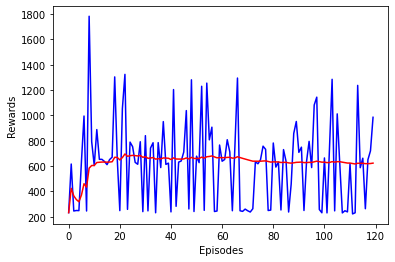

Episode:  120 reward:  810.0
Episode:  121 reward:  253.0
Updated the target Model
Episode:  122 reward:  822.0
Episode:  123 reward:  624.0
Episode:  124 reward:  667.0
Episode:  125 reward:  1138.0
Episode:  126 reward:  602.0
Episode:  127 reward:  257.0
Episode:  128 reward:  720.0
Episode:  129 reward:  228.0


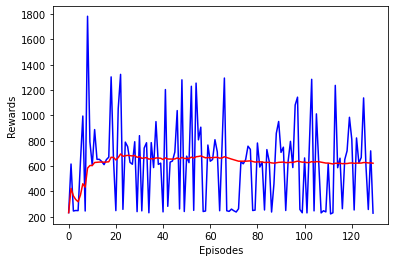

Episode:  130 reward:  258.0
Episode:  131 reward:  646.0
Episode:  132 reward:  612.0
Episode:  133 reward:  741.0
Episode:  134 reward:  239.0
Episode:  135 reward:  248.0
Episode:  136 reward:  255.0
Episode:  137 reward:  1234.0
Episode:  138 reward:  247.0
Episode:  139 reward:  257.0


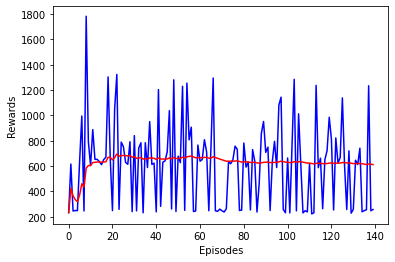

Episode:  140 reward:  248.0
Episode:  141 reward:  1215.0
Episode:  142 reward:  1008.0
Episode:  143 reward:  629.0
Episode:  144 reward:  804.0
Episode:  145 reward:  826.0
Episode:  146 reward:  634.0
Episode:  147 reward:  282.0
Episode:  148 reward:  783.0
Episode:  149 reward:  734.0


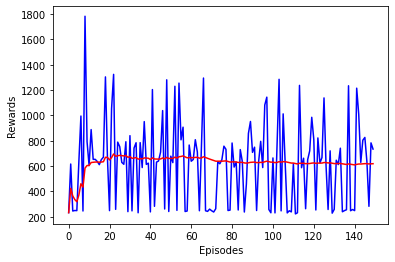

Episode:  150 reward:  631.0
Episode:  151 reward:  699.0
Episode:  152 reward:  245.0
Episode:  153 reward:  249.0
Episode:  154 reward:  653.0
Episode:  155 reward:  246.0
Episode:  156 reward:  613.0
Episode:  157 reward:  257.0
Episode:  158 reward:  961.0
Episode:  159 reward:  636.0


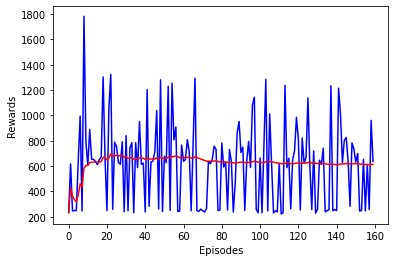

Episode:  160 reward:  633.0
Episode:  161 reward:  633.0
Episode:  162 reward:  233.0
Episode:  163 reward:  244.0
Episode:  164 reward:  1302.0
Episode:  165 reward:  231.0
Episode:  166 reward:  897.0
Episode:  167 reward:  603.0
Episode:  168 reward:  715.0
Episode:  169 reward:  876.0


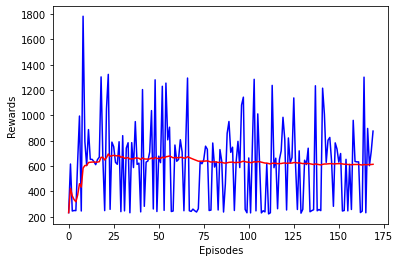

Episode:  170 reward:  243.0
Episode:  171 reward:  1332.0
Episode:  172 reward:  631.0
Episode:  173 reward:  261.0
Episode:  174 reward:  636.0
Episode:  175 reward:  1355.0
Episode:  176 reward:  738.0
Episode:  177 reward:  521.0
Episode:  178 reward:  650.0
Episode:  179 reward:  245.0


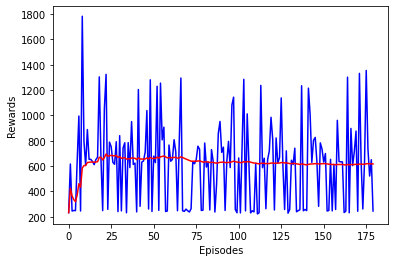

Episode:  180 reward:  1299.0
Episode:  181 reward:  260.0
Episode:  182 reward:  782.0
Episode:  183 reward:  1323.0
Episode:  184 reward:  640.0
Episode:  185 reward:  903.0
Episode:  186 reward:  1165.0
Episode:  187 reward:  258.0
Episode:  188 reward:  1321.0
Episode:  189 reward:  1035.0


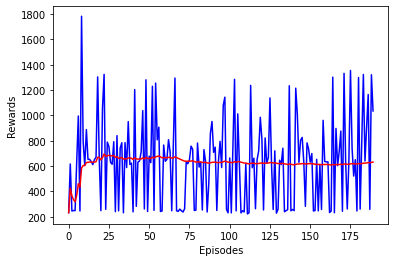

Episode:  190 reward:  628.0
Episode:  191 reward:  618.0
Episode:  192 reward:  682.0
Episode:  193 reward:  679.0
Episode:  194 reward:  250.0
Episode:  195 reward:  699.0
Episode:  196 reward:  1458.0
Episode:  197 reward:  1164.0
Episode:  198 reward:  626.0
Episode:  199 reward:  258.0


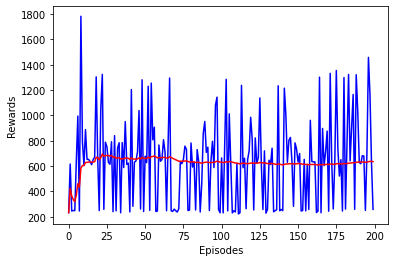

Episode:  200 reward:  233.0
Episode:  201 reward:  637.0
Episode:  202 reward:  596.0
Episode:  203 reward:  247.0
Episode:  204 reward:  231.0
Episode:  205 reward:  770.0
Episode:  206 reward:  1351.0
Episode:  207 reward:  1155.0
Episode:  208 reward:  261.0
Episode:  209 reward:  260.0


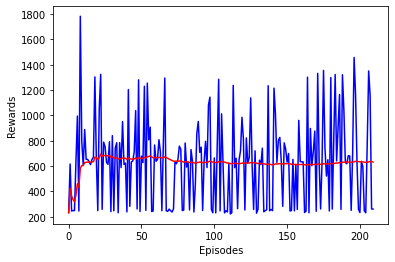

Episode:  210 reward:  861.0
Episode:  211 reward:  654.0
Episode:  212 reward:  651.0
Episode:  213 reward:  230.0
Episode:  214 reward:  282.0
Episode:  215 reward:  743.0
Episode:  216 reward:  929.0
Episode:  217 reward:  233.0
Episode:  218 reward:  458.0
Episode:  219 reward:  1495.0


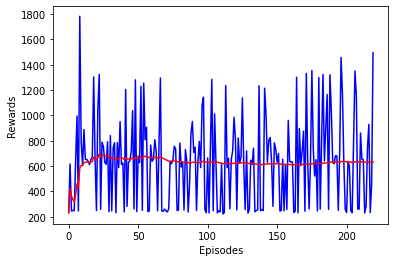

Episode:  220 reward:  637.0
Episode:  221 reward:  603.0
Updated the target Model
Episode:  222 reward:  856.0
Episode:  223 reward:  246.0
Episode:  224 reward:  653.0
Episode:  225 reward:  627.0
Episode:  226 reward:  621.0
Episode:  227 reward:  802.0
Episode:  228 reward:  1161.0
Episode:  229 reward:  764.0


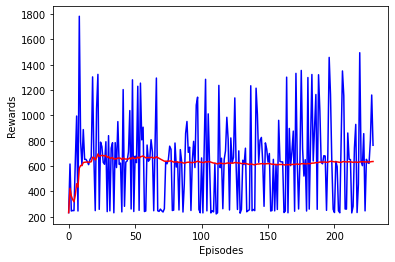

Episode:  230 reward:  626.0
Episode:  231 reward:  621.0
Episode:  232 reward:  747.0
Episode:  233 reward:  637.0
Episode:  234 reward:  260.0
Episode:  235 reward:  637.0
Episode:  236 reward:  824.0
Episode:  237 reward:  251.0
Episode:  238 reward:  237.0
Episode:  239 reward:  654.0


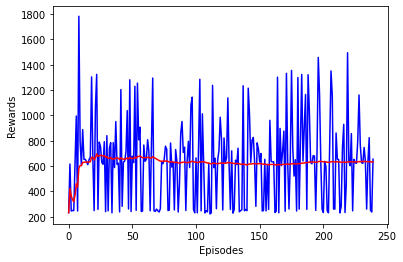

Episode:  240 reward:  260.0
Episode:  241 reward:  756.0
Episode:  242 reward:  665.0
Episode:  243 reward:  254.0
Episode:  244 reward:  259.0
Episode:  245 reward:  653.0
Episode:  246 reward:  618.0
Episode:  247 reward:  622.0
Episode:  248 reward:  255.0
Episode:  249 reward:  731.0


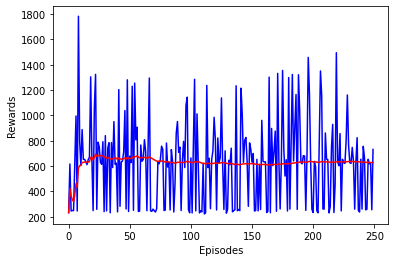

Episode:  250 reward:  246.0
Episode:  251 reward:  639.0
Episode:  252 reward:  624.0
Episode:  253 reward:  650.0
Episode:  254 reward:  711.0
Episode:  255 reward:  574.0
Episode:  256 reward:  610.0
Episode:  257 reward:  253.0
Episode:  258 reward:  606.0
Episode:  259 reward:  627.0


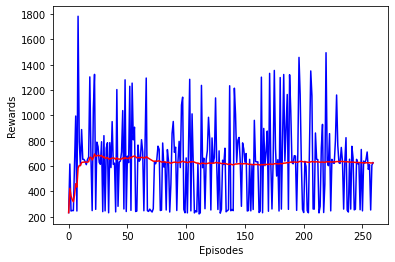

Episode:  260 reward:  961.0
Episode:  261 reward:  907.0
Episode:  262 reward:  262.0
Episode:  263 reward:  769.0
Episode:  264 reward:  762.0


In [ ]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, ACTION_SPACE)    # An environment wrapper to convert binary to discrete action space.
# apply the wrapper
env = wrapper(env, FRAME_DIM)

# create the network
policy_net = DQNetwork(stacked_frame_dim=FRAME_DIM, num_actions=env.action_space.n)
target_net = DQNetwork(stacked_frame_dim=FRAME_DIM, num_actions=env.action_space.n)

# create the replay memory
replay_memory = ReplayMemory(REPLAY_MEMORY_CAPACITY)

# play the episodes
current_exploration = EXPLORATION_MAX
total_steps = 0
reward_history = []
mean_reward_history = []
for episode in range(NUM_EPISODES):
    state = env.reset()

    # play one game
    current_reward = 0
    for steps in count(MAX_STEPS_PER_GAME):
        # render the environment
        if RENDER_ENVIRONMENT:
            env.render()

        # get the next action
        action = get_next_action(state, env.action_space.n, current_exploration)

        # perform the action
        next_state, reward, done, info = env.step(action)

        # if we are done end the loop
        if done or info["life"] < 2:
            print("Episode: ", episode, "reward: ", current_reward)
            reward_history.append(current_reward)
            mean_reward_history.append(np.mean(reward_history))
            break

        # add the transition to the replay memory
        replay_memory.push(state, action, reward, next_state, done)

        # increase the current reward and the total steps
        current_reward += reward
        total_steps += 1

        # train the policy network
        if total_steps % TRAIN_FREQUENCE == 0:
            train_policy_model(replay_memory, policy_net.model, target_net.model)

        # update the weights of the target model if necessary
        if total_steps % TARGET_NETWORK_UPDATE_FREQUENCE == 0:
            print("Updated the target Model")
            target_net.model.set_weights(policy_net.model.get_weights())

        # update the exploration rate
        current_exploration -= EXPLORATION_DECAY
        current_exploration = max(EXPLORATION_MIN, current_exploration)

    # plot the reward history
    if (episode + 1) % 10 == 0 and episode > 100:
        plt.plot(reward_history, "b-", mean_reward_history, "r-")
        plt.ylabel("Rewards")
        plt.xlabel("Episodes")
        plt.show()
